In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Add, LSTM, Activation, Flatten, Dropout, SimpleRNN, Bidirectional, Conv1D, GRU, Input, BatchNormalization
from keras.models import Model
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
from googlefinance.client import get_price_data, get_prices_data, get_prices_time_data
import fix_yahoo_finance as yf
%matplotlib inline

Using TensorFlow backend.


In [28]:
Stock="AAPL"
param = {
    'q': Stock, # Stock symbol (ex: "AAPL")
    'i': "86400", # Interval size in seconds ("86400" = 1 day intervals)
    # Stock exchange symbol on which stock is traded (ex: "NASD")
     'p':'5Y'# Period (Ex: "1Y" = 1 year)
}
# get price data (return pandas dataframe)
#df = get_price_data(param)
  
df = yf.download(Stock,'2001-06-27')
df.to_csv(Stock+'.csv')
#df=pd.read_csv(Stock+'.csv')
df.head()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-06-27,1.702143,1.714286,1.607143,1.667143,1.124248,93532600
2001-06-28,1.646429,1.707857,1.638571,1.681429,1.133882,87102400
2001-06-29,1.690000,1.792857,1.657143,1.660714,1.119913,128847600
2001-07-02,1.688571,1.730714,1.652857,1.707143,1.151222,57512000
2001-07-03,1.679286,1.727143,1.678571,1.702857,1.148332,28135800


In [3]:
Stock="AAPL"
params = [
    # Dow Jones
    {
        'q': Stock,
        'x': "NASD"
    }
]
period = "15Y"
interval = 60*72*60 # 30 minutes
# get open, high, low, close, volume time data (return pandas dataframe)
df = get_prices_time_data(params, period, interval)
df.columns=['Open','High','Low','Close','Volume']
df.to_csv(Stock+'.csv')
#df=pd.read_csv(Stock+'.csv')
df.head()

,Open,High,Low,Close,Volume
2003-07-28 13:00:00,1.5357,1.5361,1.4900,1.4993,42591220
2003-07-29 13:00:00,1.5007,1.5057,1.4657,1.4800,49324660
2003-07-30 13:00:00,1.4836,1.4929,1.4407,1.4486,43398600
2003-07-31 13:00:00,1.4807,1.5250,1.4693,1.5057,75376840
2003-08-01 13:00:00,1.4993,1.5193,1.4743,1.4807,37674462


In [29]:
data=df
btc_trace = go.Scatter(x=data.index, y=data['Close'], name= 'Price')
py.iplot([btc_trace])

In [30]:
data['Close'].replace(0, np.nan, inplace=True)
data['Close'].fillna(method='ffill', inplace=True)

In [6]:
btc_trace = go.Scatter(x=data.index, y=data['Close'], name= 'Price')
py.iplot([btc_trace])

In [31]:
predictDates = data.tail(len(data)).index

In [33]:
predictDates

DatetimeIndex(['2013-11-18', '2013-11-19', '2013-11-20', '2013-11-21',
               '2013-11-22', '2013-11-25', '2013-11-26', '2013-11-27',
               '2013-11-29', '2013-12-02',
               ...
               '2018-06-25', '2018-06-26', '2018-06-27', '2018-06-28',
               '2018-06-29', '2018-07-02', '2018-07-03', '2018-07-05',
               '2018-07-06', '2018-07-09'],
              dtype='datetime64[ns]', name='Date', length=1167, freq=None)

In [32]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [33]:
#values = data[['Weighted'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
values = data[['Open'] + ['High'] + ['Low'] + ['Close']]
values.insert(2,'Volume',data['Volume'])#.rolling(window=50).mean())
values.insert(3,'MA50',data['Close'].rolling(window=50).mean())
values.insert(4,'MA150',data['Close'].rolling(window=150).mean())
values.insert(5, 'EMA20', data['Close'].ewm(span=20, adjust=False).mean())
#values.insert(5,'open', data['Open'])
#values=values.iloc[:,1:]
values.dropna(inplace=True)
#values=values.values
values = values.astype('float32')

C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [117]:
values = (values.values[:-1,:]/values.values[1:,:])
values

array([[ 0.98007846,  1.        ,  0.76456749, ...,  0.99460107,
         1.03850961,  1.03161716],
       [ 1.03853941,  1.02728307,  1.71799779, ...,  0.99662828,
         1.00290692,  1.0152266 ],
       [ 1.01024592,  1.02638018,  0.97889745, ...,  0.99804527,
         1.03038061,  1.01123548],
       ..., 
       [ 0.99684036,  0.99389273,  1.11897135, ...,  0.99749529,
         0.9980253 ,  0.99065799],
       [ 0.99203533,  0.99433559,  0.8775056 , ...,  0.99804294,
         0.99390525,  1.00314093],
       [ 0.99805117,  1.00409925,  0.88330472, ...,  0.99984276,
         1.0183568 ,  1.01691282]], dtype=float32)

In [34]:
values = values.values 
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values)
scaled = scaler.transform(values)
#scaled = normalize(values, norm='l2')

In [35]:
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.utils import shuffle
data_gen = TimeseriesGenerator(scaled[:4000], scaled[:4000,-1],
                               length=14, sampling_rate=1,
                               stride=1, batch_size=len(scaled[:4000]))
X, y = data_gen[0]
#X, y = shuffle(X, y, random_state = 0)
print(X.shape, y.shape)
data_gen2 = TimeseriesGenerator(scaled[4000:], scaled[4000:,-1],
                               length=14, sampling_rate=1,
                               stride=1, batch_size=len(scaled[4000:]),shuffle=False)
test_X, test_y = data_gen2[0]
#test_X, test_y = shuffle(test_X, test_y, random_state = 0)
test_X.shape, test_y.shape

(3985, 14, 8) (3985,)


((134, 14, 8), (134,))

In [30]:
y = np.array(scaled[:14,-1])
for i in range(1,4000):
    y = np.append(y, scaled[i:14+i,-1], axis = 0)
print(y.shape)
test_y = np.array(scaled[4000:4014,-1])
for i in range(4001,len(scaled)-4000):
    test_y = np.append(test_y, scaled[i:14+i,-1], axis = 0)
print(test_y.shape)

(56000,)
(14,)


In [125]:
y = np.ediff1d(scaled[:4000,-1])
X = X[:-1]
y = y[:-(len(y)-len(X))]
y1 = np.empty([len(y),2])
for i in range(len(y)):
    if y[i] > 0:
        y1[i] = [1,0]
    else:
        y1[i] = [0,1]
print(X.shape, y1.shape)

test_y = np.ediff1d(scaled[4000:,-1])
test_X = test_X[:-1]
test_y = test_y[:-(len(test_y)-len(test_X))]
test_y1 = np.empty([len(test_y),2])
for i in range(len(test_y)):
    if test_y[i] > 0:
        test_y1[i] = [1,0]
    else:
        test_y1[i] = [0,1]
print(test_X.shape, test_y1.shape)

(3984, 14, 8) (3984, 2)
(133, 14, 8) (133, 2)


In [41]:
X = scaled[:14].reshape(1,14,8)
y = scaled[28,-1]
for i in range(1,500):
    if 14*(i+2)<len(scaled):
        X = np.append(X, scaled[(14*(i)):(14*(i+1)),:].reshape(1,14,8), axis=0)
        y = np.append(y, scaled[14*(i+2),-1])
X.shape, y.shape

((416, 14, 8), (416,))

In [36]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.001, shuffle=False)
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape)

(3981, 14, 8) (3981,) (4, 14, 8) (4,)


In [ ]:
train_X = X[:700]
test_X = X[700:]
train_y = y[:700]
test_y = y[700:]
train_X.shape, train_y.shape, test_X.shape, test_y.shape

In [95]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
1,0.004007,0.003982,0.003647,0.003765,0.003719,0.003949,0.003812,0.003839
2,0.003719,0.003949,0.003812,0.003839,0.003945,0.004387,0.003909,0.003732
3,0.003945,0.004387,0.003909,0.003732,0.003937,0.004067,0.003886,0.003971
4,0.003937,0.004067,0.003886,0.003971,0.003889,0.004048,0.004020,0.003949
5,0.003889,0.004048,0.004020,0.003949,0.003922,0.003897,0.003838,0.003710


In [96]:
reframed.drop(reframed.columns[[4,5,6]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var4(t)
1   0.004007   0.003982   0.003647   0.003765  0.003839
2   0.003719   0.003949   0.003812   0.003839  0.003732
3   0.003945   0.004387   0.003909   0.003732  0.003971
4   0.003937   0.004067   0.003886   0.003971  0.003949
5   0.003889   0.004048   0.004020   0.003949  0.003710


In [136]:
reframed.insert(3,'dif(t-1)', reframed.iloc[:,2]-reframed.iloc[:,3])
reframed.insert(6,'dif(t)', reframed.iloc[:,5]-reframed.iloc[:,6])
reframed.drop(reframed.columns[[2,5]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),dif(t-1),var4(t-1),dif(t),var6(t-1),var7(t-1),var8(t-1),var8(t)
1,0.527153,0.483573,-0.221688,0.508156,0.309751,0.666071,0.864780,0.622951,0.257450
2,0.418121,0.426288,-0.352815,0.542809,0.287834,0.631190,0.685701,0.257450,0.472461
3,0.375777,0.339987,-0.150353,0.383501,0.304638,0.657382,0.671324,0.472461,0.323132
4,0.423690,0.415137,-0.230656,0.424036,0.339245,0.653718,0.551924,0.323132,0.378367
5,0.349190,0.311911,-0.117425,0.398104,0.294338,0.654249,0.481923,0.378367,0.402458


In [97]:
values = reframed.values
n_train_hours = int(len(values) * 0.9)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1:]
test_X, test_y = test[:, :-1], test[:, -1:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3865, 1, 4) (3865, 1) (430, 1, 4) (430, 1)


In [30]:
from keras.callbacks import ReduceLROnPlateau
multi_model = Sequential()
multi_model.add(Bidirectional(GRU(300, return_sequences=True), input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Bidirectional(GRU(200)))
multi_model.add(Dense(1))
ad = optimizers.Adam(lr=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-6)
multi_model.compile(loss='mse', optimizer=ad)
multi_history = multi_model.fit(train_X, train_y, epochs=50, batch_size=100, callbacks=[reduce_lr],  validation_data=(test_X, test_y), verbose=0, shuffle=False)

In [104]:
from keras.callbacks import ReduceLROnPlateau
inp = Input(shape=(train_X.shape[1], train_X.shape[2]))
#out = BatchNormalization(axis=1)(inp)
out = Bidirectional(GRU(300, return_sequences=True, activation='relu'))(inp)
out = Bidirectional(GRU(200,dropout=0.1,activation='relu'))(out)
out = Dense(1)(out)
model = Model(inp,out)
ad = optimizers.Adam(lr=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-6)
model.compile(loss='mse', optimizer=ad)
multi_history = model.fit(train_X, train_y, epochs=30, batch_size=100, callbacks=[reduce_lr],  validation_data=(test_X, test_y), verbose=0, shuffle=False)

In [112]:
from keras.callbacks import ReduceLROnPlateau
inp = Input(shape=(train_X.shape[1], train_X.shape[2]))
#out = BatchNormalization(axis=1)(inp)
out=inp
for i in range(3):
    out = Bidirectional(SimpleRNN(32*2**i, return_sequences=True))(out)
    out = Activation('relu')(out)
gru1 = Bidirectional(SimpleRNN(128, return_sequences=True,init='he_normal'))(out)
gru1 = Activation('relu')(gru1)
gru1_b = Bidirectional(SimpleRNN(128, return_sequences=True, go_backwards=True,init='he_normal'))(out)
gru1_b = Activation('relu')(gru1_b)
merge1 = Add()([gru1,gru1_b])

gru2 = Bidirectional(SimpleRNN(128, return_sequences=True,init='he_normal'))(merge1)
gru2 = Activation('relu')(gru2)
gru2_b = Bidirectional(SimpleRNN(128, return_sequences=True, go_backwards=True,init='he_normal'))(merge1)
gru2_b = Activation('relu')(gru2_b)
merge2 = Add()([gru2,gru2_b])

out = Bidirectional(SimpleRNN(512))(merge2)
out = Dense(1)(out)
model = Model(inp,out)
ad = optimizers.Adam(lr=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-6)
model.compile(loss='mse', optimizer=ad)
multi_history = model.fit(train_X, train_y, epochs=30, batch_size=100, callbacks=[reduce_lr],  validation_data=(test_X, test_y), verbose=0, shuffle=True)

C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning:

Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(128, return_sequences=True, kernel_initializer="he_normal")`

C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning:

Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(128, return_sequences=True, go_backwards=True, kernel_initializer="he_normal")`

C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning:

Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(128, return_sequences=True, kernel_initializer="he_normal")`

C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning:

Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(128, return_sequences=True, go_backwards=True, kernel_initializer="h

In [37]:
from keras.callbacks import ReduceLROnPlateau
def tcn(h,filters=100, kernel_size=2, padding='causal', activation='relu', dilation_rate=1):
    #main = BatchNormalization()(h)
    main = h
    for i in range(2):
        main = Conv1D(filters=filters,kernel_size=kernel_size,padding=padding, dilation_rate=dilation_rate)(main)
        #main = BatchNormalization()(main)
        main = Activation('relu')(main)
        main = Dropout(0.25)(main)
    side_path = Conv1D(filters=filters,kernel_size=1, padding='same')(h)
    #side_path = BatchNormalization()(side_path)
    return Add()([main,side_path])

Inp = Input(shape=(14,8))
inp = Inp
D = [1,2,4]
for i in range(3):
    inp=tcn(inp,dilation_rate=D[i])
    #inp = BatchNormalization()(inp)
    #inp = Activation('relu')(inp)
inp=Flatten()(inp)
out=Dense(1)(inp)
model = Model(Inp,out)
ad = optimizers.Adam(lr=0.002)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-8)
model.compile(loss='mse', optimizer=ad, metrics=['accuracy'])
history = model.fit(train_X, train_y, epochs=200, batch_size=128, validation_split=0.1, verbose=0, shuffle=False)


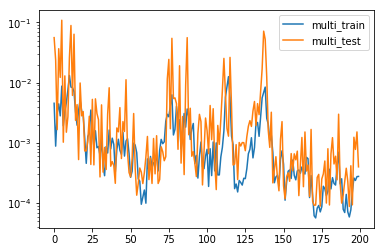

In [38]:
pyplot.plot(history.history['loss'], label='multi_train')
pyplot.plot(history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.yscale('log')
pyplot.show()

In [49]:
data_gen2 = TimeseriesGenerator(scaled[4000:], scaled[4000:,-1],
                               length=14, sampling_rate=1,
                               stride=14, batch_size=len(scaled[4000:]),shuffle=False)
test_X, test_y = data_gen2[0]
#test_X, test_y = shuffle(test_X, test_y, random_state = 2)
test_X.shape, test_y.shape

((131, 14, 8), (131,))

In [131]:
scale=scaled[::-1,:]
data_gen3 = TimeseriesGenerator(scale, scale[:,-1],
                               length=14, sampling_rate=1,
                               stride=14, batch_size=len(scale),reverse=False)
test_X, test_y = data_gen3[0]
test_X.shape, test_y.shape

((416, 14, 8), (416,))

In [23]:
test_X = scaled[-28:-14].reshape(1,14,4)
test_y = scaled[-14,-1]
for i in range(2,100):
    test_X = np.append(test_X, scaled[(-14*(i+1)):(-14*i)].reshape(1,14,4), axis=0)
    test_y = np.append(test_y, scaled[-14*(i),-1])

In [39]:
pred = model.evaluate(test_X,test_y)
pred

134/134 [==============================] - 0s 2ms/step


[0.0012625917121628994, 0.0074626867895695699]

In [19]:
model.predict(scaled[-16:-2,:].reshape(1,14,8))

array([[ 1.37212002]], dtype=float32)

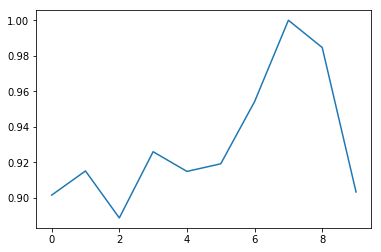

In [20]:
pyplot.plot(scaled[-10:,-1])
pyplot.show()

In [40]:
pred = model.predict(test_X)

In [41]:
diff1=np.concatenate((np.ediff1d(test_y).reshape(len(test_y)-1,1),np.ediff1d(pred[:,0]).reshape(len(pred[:])-1,1)),axis=1)
mul = np.multiply(diff1[:,0],diff1[:,1])
len(mul[mul>=0])/len(mul)

0.48872180451127817

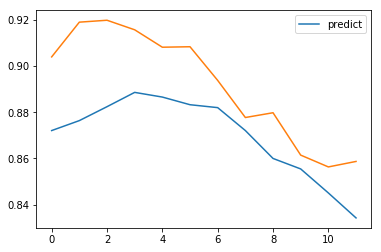

In [43]:
pyplot.plot(pred[:12,:].reshape(12,1),label='predict')
pyplot.plot(test_y[:12].reshape(12,1))
pyplot.legend()
pyplot.show()

In [27]:
pyplot.plot(np.append(scaled[-10:,-1],model.predict(scaled[-14:].reshape(1,14,4))))
pyplot.show()

ValueError: cannot reshape array of size 112 into shape (1,14,4)

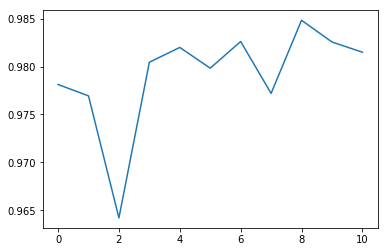

In [76]:
pyplot.plot(np.append(scaled[-11:-1,-1],model.predict(scaled[-15:-1].reshape(1,14,4))))
pyplot.show()

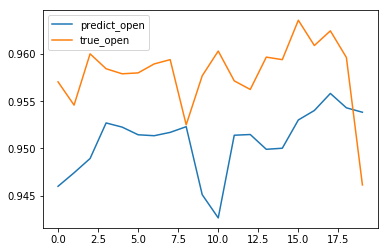

In [303]:
#yhat = multi_model.predict(test_X)
pyplot.plot(yhat[-20:,0], label='predict_open')
#pyplot.plot(yhat[-20:,1], label='predict_close')
pyplot.plot(test_y[-20:,0], label='true_open')
#pyplot.plot(test_y[-20:,1], label='true_close')
pyplot.legend()
pyplot.show()


In [302]:
diff1=np.concatenate((np.ediff1d(test_y[:,0]).reshape(len(test_y[:])-1,1),np.ediff1d(yhat[:,0]).reshape(len(yhat[:])-1,1)),axis=1)
mul = np.multiply(diff1[:,0],diff1[:,1])
len(mul[mul>=0])/len(mul)

0.7385110294117647

In [159]:
diff2=np.concatenate((np.ediff1d(test_y[:,1]).reshape(len(test_y[:])-1,1),np.ediff1d(yhat[:,1]).reshape(len(yhat[:])-1,1)),axis=1)
mul = np.multiply(diff2[:,0],diff2[:,1])
len(mul[mul>=0])/len(mul)

IndexError: index 1 is out of bounds for axis 1 with size 1

In [59]:
mul = np.multiply((yhat[:,0]-yhat[:,1]),(test_y[:,0]-test_y[:,1]))
len(mul[mul>=0])/len(mul)

1.0

In [139]:
test_y[-10:,:]

array([[-0.01458383, -0.01615983],
       [ 0.00653565,  0.00436211],
       [ 0.00482965, -0.00557637],
       [-0.00603473, -0.00291175],
       [-0.01461422, -0.0148713 ],
       [-0.00223547,  0.01240599],
       [ 0.01224101, -0.00146389],
       [-0.00610048,  0.0072763 ],
       [ 0.01189566, -0.00210243],
       [-0.01325881,  0.01118255]], dtype=float32)

In [140]:
yhat[-10:,:]

array([[  3.74157238e-03,  -3.48474976e-04],
       [ -7.80324964e-03,  -4.15248011e-04],
       [  1.89828407e-03,   1.14499300e-03],
       [ -4.83561680e-03,   8.56241968e-04],
       [ -1.00375082e-05,   4.52852779e-04],
       [ -4.91447141e-03,  -3.30437120e-04],
       [  1.17466841e-02,   8.54853366e-04],
       [ -4.75058332e-03,   1.41787750e-03],
       [  7.40860868e-03,   1.34658389e-04],
       [ -5.96417580e-03,   9.10977658e-04]], dtype=float32)

In [79]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, :-2],yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-2:]
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :-2], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-2:]

In [23]:
diff=np.concatenate((np.ediff1d(inv_y[:-1]).reshape(len(inv_y[:-1])-1,1),np.ediff1d(inv_yhat[1:]).reshape(len(inv_yhat[1:])-1,1)),axis=1)
mul = np.multiply(diff[:,0],diff[:,1])
len(mul[mul>=0])/len(mul)

ValueError: cannot reshape array of size 301 into shape (150,1)

In [80]:
diff2=np.concatenate((np.ediff1d(inv_y[:-1,1]).reshape(len(inv_y[:-1])-1,1),np.ediff1d(inv_yhat[1:,1]).reshape(len(inv_yhat[1:])-1,1)),axis=1)
mul = np.multiply(diff2[:,0],diff2[:,1])
len(mul[mul>=0])/len(mul)

0.58

In [81]:
rmse = sqrt(mean_squared_error(inv_y[:-1], inv_yhat[1:]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.017


In [82]:
mul = np.multiply((inv_yhat[:,0]-inv_yhat[:,1]),(inv_y[:,0]-inv_y[:,1]))
len(mul[mul>=0])/len(mul)

0.7039473684210527

In [83]:
inv_y[-10:]

array([[ 0.98541617,  0.98384017],
       [ 1.00653565,  1.00436211],
       [ 1.00482965,  0.99442357],
       [ 0.99396533,  0.99708825],
       [ 0.98538584,  0.9851287 ],
       [ 0.99776453,  1.01240599],
       [ 1.01224101,  0.99853611],
       [ 0.99389952,  1.0072763 ],
       [ 1.01189566,  0.99789762],
       [ 0.98674119,  1.01118255]], dtype=float32)

In [85]:
inv_yhat[-10:]

array([[ 1.00401413,  0.99980313],
       [ 0.99262673,  0.99915171],
       [ 1.00147188,  1.00115454],
       [ 0.99380815,  0.99953389],
       [ 1.00057268,  1.00155473],
       [ 0.99327999,  0.99765897],
       [ 1.01094258,  1.00023043],
       [ 0.99478573,  1.00150871],
       [ 1.00887501,  1.00213003],
       [ 0.99447578,  1.00167549]], dtype=float32)